Import all the required packages

In [260]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import expit
from scipy.optimize import minimize
from decimal import Decimal

In [261]:
#Computes the sigmoid function
def sigmoid(z):
    g = 1.0 / (1.0 + np.exp(-z))
    return g

In [262]:
#Compute the gradient of the sigmoid function
def GradientSigmoid(z):
    g = sigmoid(z)
    g = g*(1-g)
    return g

In [263]:
def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure()
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    plt.set_cmap("gray")
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

Regularized cost function for a multilayer neural network

$$a^{(1)}=x$$ 
(Add $a_{0}^{(1)}$)
$$z^{(2)}=\Theta^{(1)}a^{(1)}$$
$$a^{(2)}= g(z^{(2)})$$
(Add $a_{0}^{(2)}$)
$$z^{(3)}=\Theta^{(2)}a^{(2)}$$
$$a^{(3)}= g(z^{(3)})=h_{\theta}(x)$$
$$J(\theta)=\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[ -y_{k}^{(i)}log((h_{\theta}(x^{(i)}))_{k})-(1-y_{k}^{(i)})log(1-((h_{\theta}(x^{(i)}))_{k})]+\frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^{2}+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^{2}]$$

In [264]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_reg):
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    m = len(X)
    Y = np.zeros((num_labels,len(y)))
    for i in range(len(y)):
        Y[y[i]-1,i]=1  
    J = 0;
    mk = num_labels*len(y)
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
        
    a1 = np.column_stack((np.ones((m,1)), X)) # = a1
    z2 = np.dot(a1,Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    z3 = np.dot(a2,Theta2.T)
    a3 = sigmoid(z3)
    h_theta = a3    
    YY = Y.reshape(mk,1)
    gg = (h_theta.T).reshape(mk,1)
    J = 1/m*((-np.dot(YY.T,np.log(gg)))-np.dot((1-YY.T),np.log(1-gg)))
    J = J+ 0.5*lambda_reg/m*(np.sum(np.square(Theta1[:,1:]))+np.sum(np.square(Theta2[:,1:])))
    
    yyk = np.arange(num_labels)
    yk = np.dot(np.ones((m,1)),yyk.reshape(1,-1)).astype(int)
    sigma3 = a3-(np.equal(yk,y.reshape(-1,1)))
    z2=np.column_stack((np.ones((m,1)),z2))
    sigma2 = np.dot(sigma3,Theta2)*GradientSigmoid(z2)
    sigma2 = np.delete(sigma2,0,axis=1)
    delta1 = np.dot(sigma2.T,a1)
    delta2 = np.dot(sigma3.T,a2)
    Theta1_grad = 1/m*delta1
    Theta2_grad = 1/m*delta2;
    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    return J, grad

In [265]:
def nnCostFunction2(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_reg):
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )

    labels = y
    y = np.zeros((m,num_labels))
    for i in range(m):
        y[i, labels[i]-1] = 1
    
    cost = 0
    for i in range(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )
    J = -(1.0/m)*cost
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))
    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )
    bigDelta1 = 0
    bigDelta2 = 0
    for t in range(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T))
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        for k in range(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * GradientSigmoid( np.dot(x, Theta1.T) )
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m
    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    return J, grad

In [266]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init
    return W

In [267]:
def checkNNGradients(lambda_reg=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1 + np.mod(range(m), num_labels).T
    nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)

    _, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    fmt = '{:<25}{}'
    print(fmt.format('Numerical Gradient', 'Analytical Gradient'))
    for numerical, analytical in zip(numgrad, grad):
        print(fmt.format(numerical, analytical))

    print('The above two columns you get should be very similar.\n' \
             '(Left Col.: Your Numerical Gradient, Right Col.: Analytical Gradient)')
    diff = Decimal(np.linalg.norm(numgrad-grad))/Decimal(np.linalg.norm(numgrad+grad))
    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {:.10E}'.format(diff))

In [268]:
def debugInitializeWeights(fan_out, fan_in):
    W = np.zeros((fan_out, 1 + fan_in))
    W = np.reshape(np.sin(range(W.size)), W.shape) / 10
    return W

In [269]:
def computeNumericalGradient(J, theta):
    numgrad = np.zeros( theta.shape )
    perturb = np.zeros( theta.shape )
    e = 1e-4
    for p in range(theta.size):
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1) / (2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0
    return numgrad

In [270]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0]
    p = np.zeros((m,1))
    X = np.column_stack((np.ones((m,1)), X))
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    p = np.argmax(a3, axis=1)
    return p + 1

Input parameters for the neural netowork

In [271]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10

Load all the images and labels

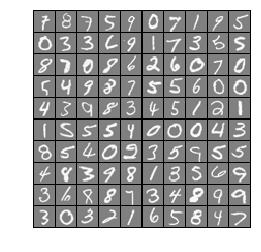

In [272]:
data = scipy.io.loadmat('../1vsAllLogisticRegression/hand_written_numbers.mat')
X=data["X"]
y=data["y"]
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);

In [274]:
mat = scipy.io.loadmat('ex3weights.mat')
Theta1 = mat["Theta1"]
Theta2 = mat["Theta2"]

nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))#
print('Feedforward Using Neural Network ...')
lambda_reg = 1

#J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_reg)
#print('Training Set Accuracy:(this value should be about 0.287629)',J)
print('Checking Cost Function (w/ Regularization)...')
#lambda_reg = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_reg)
print('Cost at parameters (loaded from ex4weights): (this value should be about 0.383770)',J)

pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:f}'.format((np.mean(pred == y)*100)))
rp = np.random.permutation(m)

print('Initializing Neural Network Parameters...')
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate((initial_Theta1.reshape(initial_Theta1.size, order='F'), initial_Theta2.reshape(initial_Theta2.size, order='F')))

print('Checking Backpropagation... ')
checkNNGradients()

#print('\nChecking Backpropagation (w/ Regularization) ... \n')
lambda_reg = 3
checkNNGradients(lambda_reg)
#debug_J, _  = nnCostFunction(nn_params, input_layer_size, \
#                         hidden_layer_size, num_labels, X, y, lambda_reg)

#print('\n\nCost at (fixed) debugging parameters (w/ lambda_reg = 3): {:f} ' \
#         '\n(this value should be about 0.576051)\n\n'.format(debug_J))

#print('Training Neural Network...')
#maxiter = 20
#lambda_reg = 0.1
#myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
#results = minimize(nnCostFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

#nn_params = results["x"]

#Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
#                 (hidden_layer_size, input_layer_size + 1), order='F')

#Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
#                 (num_labels, hidden_layer_size + 1), order='F')

#print('\nVisualizing Neural Network... \n')

#displayData(Theta1[:, 1:])

#pred = predict(Theta1, Theta2, X)

# uncomment code below to see the predictions that don't match
# fmt = '{}   {}'
# print(fmt.format('y', 'pred'))
# for y_elem, pred_elem in zip(y, pred):
#     if y_elem != pred_elem:
#         print(fmt.format(y_elem%10, pred_elem%10))

#print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )




#for i in range(m):
#    print('Displaying Example Image')
#    displayData(X[rp[i], :].reshape(1,-1))
#    pred = predict(Theta1, Theta2, X[rp[i], :])
#    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred%10)[0]))
#    input('Program paused. Press enter to continue.\n')


Feedforward Using Neural Network ...
Checking Cost Function (w/ Regularization)...
Cost at parameters (loaded from ex4weights): (this value should be about 0.383770) [[ 0.38376986]]
Training Set Accuracy: 97.520000
Initializing Neural Network Parameters...
Checking Backpropagation... 
Numerical Gradient       Analytical Gradient
0.006906540832574137     0.013220367091081726
0.01212510425840918      0.01626051660072767
0.006198479012287095     0.004365222558112418
-0.005423556828088039    -0.011547854069492136
-0.012076102853253445    -0.016857350486613666
-0.00011085270923416601  -0.0001783639895799786
-4.2982200021413064e-05  -0.0001974372386003872
6.418726661294727e-05    -3.513158165906897e-05
0.00011254971621355025   0.0001595795991133149
5.72000580234544e-05     0.000207575100226972
0.0001438518348884088    0.0002694491812292948
0.00015166618849704605   0.00046500185508380876
2.030122070451057e-05    0.00023309185780068885
-0.0001300184759855938   -0.0002131926044282805
-0.0001605